In [7]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid
import diffusers
import torch
from transformers import CLIPVisionModelWithProjection
from sfast.compilers.diffusion_pipeline_compiler import (compile,
                                                         CompilationConfig)

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16
)

# use from_pipe to avoid consuming additional memory when loading a checkpoint
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True, image_encoder=image_encoder,
).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter-plus-face_sdxl_vit-h.bin")

pipeline.scheduler = diffusers.EulerDiscreteScheduler.from_config(
    pipeline.scheduler.config
)

pipeline.load_lora_weights('animte/pixar-sdxl-lora', weight_name='PixarXL.safetensors', adapter_name="pixar-style")

config = CompilationConfig.Default()
# xformers and Triton are suggested for achieving best performance.
try:
    import xformers
    config.enable_xformers = True
except ImportError:
    print('xformers not installed, skip')
try:
    import triton
    config.enable_triton = True
except ImportError:
    print('Triton not installed, skip')
# CUDA Graph is suggested for small batch sizes and small resolutions to reduce CPU overhead.
# But it can increase the amount of GPU memory used.
# For StableVideoDiffusionPipeline it is not needed.
config.enable_cuda_graph = True

pipeline = pipeline.to("cuda")

pipeline = compile(pipeline, config)
# pipeline = compile(pipeline, config)

/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
from PIL import Image
import math

def create_collage(images, size=(1024, 1024)):
    num_images = len(images)
    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    img_width = size[0] // cols
    img_height = size[1] // rows

    collage = Image.new('RGB', size)

    x_offset = 0
    y_offset = 0
    for i, img in enumerate(images):
        # Resize and crop the image to fit
        img_aspect = img.width / img.height
        cell_aspect = img_width / img_height
        if img_aspect > cell_aspect:
            new_width = int(img_height * img_aspect)
            img = img.resize((new_width, img_height), Image.LANCZOS)
            left = (new_width - img_width) // 2
            img = img.crop((left, 0, left + img_width, img_height))
        else:
            new_height = int(img_width / img_aspect)
            img = img.resize((img_width, new_height), Image.LANCZOS)
            top = (new_height - img_height) // 2
            img = img.crop((0, top, img_width, top + img_height))

        collage.paste(img, (x_offset, y_offset))
        x_offset += img_width
        if (i + 1) % cols == 0:
            x_offset = 0
            y_offset += img_height

    return collage

2024-07-22 16:32:47.716077035 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-07-22 16:32:48.021242623 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-07-22 16:32:48.046113194 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0


2024-07-22 16:32:48.082482307 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-07-22 16:32:48.131553895 [E:onnxruntime:Default, provider_bridge_ort.cc:1745 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/danielko/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


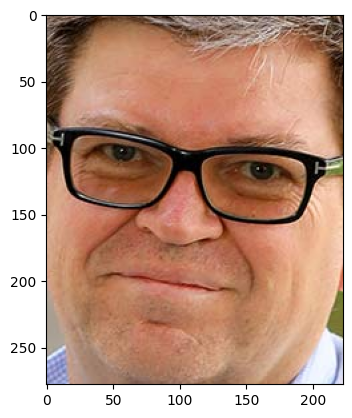

INFO:root:Dynamically graphing forward
INFO:root:Tracing forward
/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return func(*args, **kwargs)
/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python list might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return func(*args, **kwargs)
/home/danielko/miniconda3/envs/pixarsd/lib/python3.10/site-packages/sfast/jit/overrides.py:21: TracerWarning: Converting a tensor to a Python boolean might c

  0%|          | 0/30 [00:00<?, ?it/s]

INFO:root:Dynamically graphing forward
INFO:root:Tracing forward


AttributeError: 'tuple' object has no attribute 'shape'

In [9]:
import cv2
from insightface.app import FaceAnalysis
import torch
import numpy as np

import matplotlib.pyplot as plt

app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

pipeline.enable_lora()

path_or_url = "https://www.adagiapartners.com/wp-content/uploads/2022/09/yann-lecun-web.jpg"
init_image = load_image(path_or_url)

faces = app.get(np.array(init_image))

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

bbox = faces[0]['bbox']
cropped_image = np.array(init_image)[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
plt.imshow(cropped_image)
plt.show()

prompt = "breathtaking 3D image in the pixar style, pixar-style, cartoon"
negative_prompt = "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo, NSFW"
H, W = 1024, 1024
n_infer_steps = 50
guidance_scale = 15.5
prompt_strength = 0.6
high_noise_frac = 0.8
num_images_per_prompt = 4

lora_scale = 0.8
ip_adapter_scale = 0.1

pipeline.set_adapters(["pixar-style"], adapter_weights=[lora_scale])
pipeline.set_ip_adapter_scale(ip_adapter_scale)

images = pipeline(prompt, 
                 negative_prompt=negative_prompt, 
                 image=init_image, 
                 strength=prompt_strength, 
                 guidance_scale=guidance_scale,
                 ip_adapter_image=cropped_image,
                 num_images_per_prompt=num_images_per_prompt,
                 target_size = (H, W),
                 clip_skip=2,
                 high_noise_frac=high_noise_frac)

image = create_collage(images.images, init_image.size)

make_image_grid([init_image, image], rows=1, cols=2)